# Reagent Logs Analysis - 12/01/2020 Sequoia

| Field | Entry                                                                                                                                                                      |
|------------|:------------------------------------------------------------------------------------------------------------------------------------------------------------------------------|
| **Instrument** | Sequoia |
| **Operator**   | Justin Costa                                       |                                                                                                                         |
| **Start Date** | 12/01/2020                                                                                                                                                                   
| **End Date**   | 12/08/2020                                        |                                                                                                                          
| **Notes**      | |

In [24]:
reagent_map = [1, 2, 3, 4, 5, 6, 8, 9, 10, 13, 18]
# reagent_map = [4, 5, 6, 7, 8, 14, 16, 18]
# reagent_map = [4, 5, 6, 7, 8, 16, 18]
bad_valve = 18

directory = 'data/20201208/'

range_dict={5:{'acceptable': (0, 0),'expected': (0,0)}, 
            75:{'acceptable': (56.25, 93.75), 'expected': (69.375, 80.625)}, 
            200:{'acceptable': (170, 230), 'expected': (185, 215)}, 
            400:{'acceptable': (340, 460), 'expected': (370, 430)}}

write_to = False

In [25]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import ast
import seaborn as sns
from sklearn.linear_model import LinearRegression
import datetime
import matplotlib.ticker as mticker
import warnings
sns.set()

import os
import yaml
import pandas as pd
import scipy
import numpy
from numpy.random import seed
from numpy.random import randn
from numpy import mean
from numpy import sqrt
from scipy.stats import chi2
from scipy.stats import norm
from scipy.stats import sem, t
from scipy.stats import linregress

warnings.simplefilter('ignore')

In [26]:
#Parses calibration files for lohmic value and other information
def confint(data, confidence=0.95):
    '''
    params: 
            data: array-like. normally distributed continuous data
            con: level of confidence to achieve. Defaults to 0.95
    Returns:
            coefficient of confidence interval
    '''
    n = len(data)
    m = mean(data)
    std_err = sem(data)
    h = std_err * t.ppf((1 + confidence) / 2, n - 1)
    return (h / m)

def tolerance_interval(data, con=0.95, cov=0.95):
    """
    From https://machinelearningmastery.com/statistical-tolerance-intervals-in-machine-learning/
    From https://www.itl.nist.gov/div898/handbook/prc/section2/prc263.htm
    Calculates the 2-sided tolerance interval using Howe's method. Does not use Guenther's k2 correction.

    params: 
            data: array-like. normally distributed continuous data
            con: level of confidence to achieve. Defaults to 0.95
            cov: percent of population covered by the interval. Defaults to 0.95
    Returns:
            lower bound, upper bound
    """

    # specify degrees of freedom
    n = len(data)
    dof = n - 1
    # specify data coverage
    cov_inv = (1.0 - cov) / 2.0
    gauss_critical = norm.isf(cov_inv)
    #specify confidence
    chi_critical = chi2.isf(q=con, df=dof)
    # k_2
    k_2 = gauss_critical * sqrt((dof * (1 + (1/n))) / chi_critical)
    # summarize
    data_mean = mean(data)
    data_std = numpy.std(data)
    lower, upper = data_mean-(k_2*data_std), data_mean+(k_2*data_std)
    return (lower, upper)

def cal_statistics(masses, pressures, dis_time, filename, reagent, valve, time):

    cols = ("filename","time", "reagent", "valve", "mass 1", "mass 2", "mass 3", "mass 4", "mass 5", "pressure 1", "pressure 2", "pressure 3", 
            "pressure 4", "pressure 5", "L1", "L2", "L3", "L4", "L5", "Lavg", "Lstdev", "L_cv_abs", "pass/fail", "lowerbound", "upperbound", "ci_cf", "p-value")
    stats_df = pd.DataFrame(columns=cols)

    vol_flow = []

    # Convert mass and dispense time to volumetric flow rate of uL/s, assuming the calibration reagent is waster (i.e. specific gravity is ~1)
    # Converts pressure to psi using transfer function developed by pressure sensor manufacturer https://sensing.honeywell.com/index.php%3Fci_id%3D45841
    for i in range(len(masses)):
        vol_flow.append((masses[i] * 1000) / (dis_time / 1000.0)) # ul/s
        # pressures[i] = ((pressures[i] - 1638) / (14745 - 1638)) * 15 # psi
    # Compute Lohm for each dispense using equations developed by Lee Co https://www.theleeco.com/sites/leecompany/assets/efs-handbook/264/
    lohm = []
    for j in range(len(masses)):
        if vol_flow[j] != 0:
            lohm.append(scipy.sqrt(float(pressures[j])) / vol_flow[j])
        else:
            lohm.append(0)

    tolerance_lower, tolerance_upper = tolerance_interval(lohm)
    ci_cf = confint(lohm)
    # print("ci_cf: {}".format(ci_cf))
    slope, intercept, r_value, p_value, std_err = linregress(lohm, [0,1,2,3,4])
    # print("p_value: {}".format(p_value))

    lohm_avg = numpy.mean(lohm)
    lohm_stdev = numpy.std(lohm)

    if lohm_avg != 0:
        lohm_cv = numpy.abs((lohm_stdev / lohm_avg) * 100)
    else:
        lohm_cv = "NaN"

    if lohm_cv > 2.0:
        pass_fail = False
    else:
        pass_fail = True

    stats_df.loc[0] = (filename, time, reagent, valve, masses[0], masses[1], masses[2], masses[3], masses[4], pressures[0], pressures[1], pressures[2],
                       pressures[3], pressures[4], lohm[0], lohm[1], lohm[2], lohm[3], lohm[4], lohm_avg, lohm_stdev, lohm_cv, pass_fail, tolerance_lower, tolerance_upper, ci_cf, p_value)

    return stats_df


df = []



for file in os.listdir(directory):
#     print(file)
    if file.endswith(".yaml"):
        filename = directory + file
#         print(file)
        stream = open(filename, 'r')
        input_map = yaml.load(stream)
        # print(input_map)
        for j in range(1, 21):
            try:
                masses = []
                pressures = []
                # reagent = input_map["reagents"]["valve_%d"%j]["short_name"]
                reagent = "valve"
                valve = j
                timestamp = input_map['creation_ts']
                time = timestamp
                # timestamp_split = timestamp.split(sep='T', maxsplit=1)
                # date = timestamp_split[0]
                # time = timestamp_split[1].split(sep='.', maxsplit=1)[0]
                # date = date.replace('-', '/')
                # time = date + " " + time
                # m/d/yyyy h:mm:ss
#                 print(time)
                # dis_time = (float(input_map['reagents']['valve_%d' % j]['dispenses']))
                for i in range(0, 5):
                    # print(float(input_map['valves']['valve_%d' % j]['dispenses'][i]['grams']))
                    masses.append(float(input_map['valves']['valve_%d' % j]['dispenses'][i]['grams']))
                    pressures.append(float(input_map['valves']['valve_%d' % j]['dispenses'][i]['mean_gauge_pressure_psi']))
                # print(masses)
                # print(pressures)
                df.append(cal_statistics(masses, pressures, 2000, filename, reagent, valve, time))
            except KeyError:
                print("couldn't find valve %d in file %s" % (j, file))
            # except IndexError:
            #     print("list index out of range, valve %d in file %s" % (j, file))

df_output = pd.concat(df)
filename = "results_yaml.csv"
df_output.to_csv(filename, sep=',', index=False)

In [27]:
df_output['time'] = pd.to_datetime(df_output['time'])

In [28]:
df_output = df_output.sort_values(by=['valve', 'time'])

### 1. Calibration Analysis

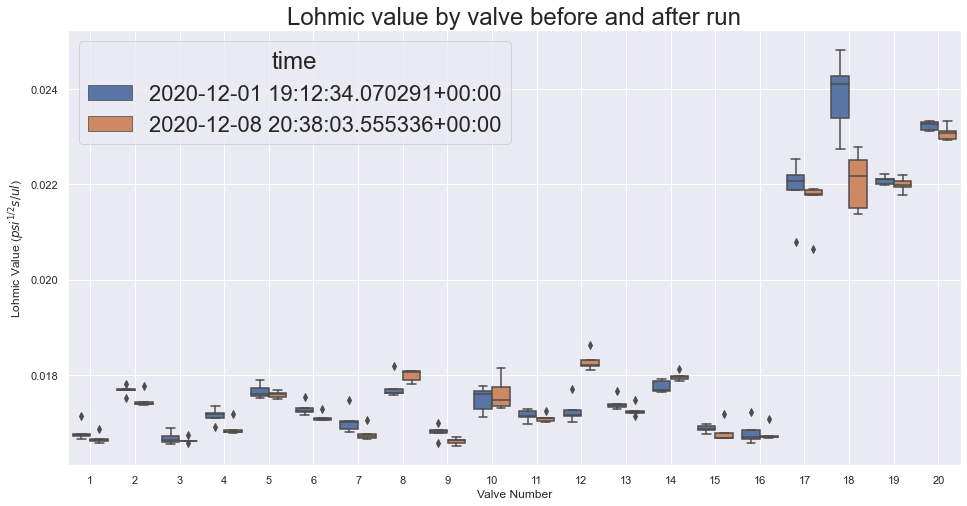

In [29]:
melt_df = pd.melt(df_output, id_vars=['time', 'valve'], value_vars=['L1', 'L2', 'L3', 'L4', 'L5'])
fig, ax = plt.subplots(figsize=(16, 8))
sns.set(font_scale=2)
sns.boxplot(data=melt_df, x='valve', y='value', hue='time')
ax.set(xlabel='Valve Number', ylabel='Lohmic Value ($psi^{1/2}s/ul$)',
      title='Lohmic value by valve before and after run')
ax.grid(axis='x')
plt.show()

- Lohmic values for all valves appear nominal with low standard deviation over the 5 dispenses used to calibrate lohmic value.
- Lohmic value does not change significantly between the beginning and end of run. Most variation likely due to changing cartridge. Valve 12 and valve 18 have the most variation
- The lohmic value standard deviation for valve 18 (WB1) before and after the run has large standard deviation. Unclear at this time if this is well outside the nominal standard deviation range. 

In [30]:
for file in os.listdir(directory):
    if file.endswith(".csv"):
        filename = directory + file
        df = pd.read_csv(filename)
        df['local_ts'] = pd.to_datetime(df['local_ts'])
instrument = df['instrument_name'].iloc[0]

In [31]:
# print(df.shape)
df = df.loc[(df['device_task_view_id'] != 'calibrate')
           & (df['device_task_view_id'] != 'prep_reagents')
           & (df['device_task_top_level'] != 'Calibrate Fluidics')
           & (df['device_task_top_level'] != 'Fluidics Preflight')].copy()

In [32]:
# Define Color and Marker map for each valve
valve_color_map = {1:['#CC99FF', '.'],
                  2: ['#CCCC00', 'v'],
                  3: ['#CC9900', 's'],
                  4: ['#CC6600', '1'],
                  5: ['#CC3300', 'P'],
                  6: ['#CC0000', 'X'],
                  7: ['#660000', 'd'],
                  8: ['#663300', '.'],
                  9: ['#666600', 'v'],
                  10:['#669900', '1'],
                  11:['#66CC00', 's'],
                  12:['#66FF00', 'P'],
                  13:['#1A237E', 'X'],
                  14:['#00FF33', 'd'],
                  15:['#00FF00', '.'],
                  16:['#00CC00', 'v'],
                  17:['#009900', 's'],
                  18:['#006600', '1'],
                  19:['#003300', 'P'],
                  20:['#0000FF', 'X']}

In [33]:
# Define function to parse differential pressure sensor data from logs
def parse_diff_pressure(df):
    dispenses_full = []
    for i in range(len(df)):
        dict_string = df['fc_sensor_data'].iloc[i]
        dispenses_full.append(ast.literal_eval(dict_string))

    curves = []
    baselines = []
    peaks = []
    AUCs = []
    gauge_pressures = []
    abs_pressures = []
    lengths = []
    
    for dispense in dispenses_full:
        length = len(dispense)
        single_dispense = []
        try:
            gauge_pressure = dispense[1][1]['gauge_pressure_psi']
            abs_pressure = dispense[1][1]['abs_pressure_bar']
        except KeyError:
            gauge_pressure = dispense[1][1]['state']['gauge_pressure_psi']
            abs_pressure = dispense[1][1]['state']['abs_pressure_bar']
        gauge_pressures.append(gauge_pressure)
        abs_pressures.append(abs_pressure)
        for point in dispense:
            try:
                single_dispense.append(-1 * point[1]['state']['diff_pressure'])
            except KeyError:
                try:
                    single_dispense.append(-1 * point[1]['diff_pressure'])
                except KeyError:
                    print("Key Error: {}".format(point))
                    pass
        try:
            baseline=single_dispense[0]
            baselines.append(baseline)
            for i in range(len(single_dispense)):
                single_dispense[i] = single_dispense[i] - baseline
            peaks.append(max(single_dispense))
            AUCs.append(np.trapz(single_dispense))
            curves.append(single_dispense)
            lengths.append(length)
        
        except IndexError:
            print("IndexError: {}".format(single_dispense))
            curves.append([0])
            baselines.append(0)
            peaks.append(0)
            AUCs.append(0)
            lengths.append(0)

    dict_to_df = {'pressure_curves': curves,
                  'length': lengths,
                 'baseline': baselines,
                 'peak': peaks,
                 'AUC': AUCs,
                 'gauge_pressure': gauge_pressures,
                 'abs_pressure': abs_pressures}
    curve_df = pd.DataFrame(dict_to_df)
    return curve_df

In [34]:
# Concatenate data to original df
curve_df = parse_diff_pressure(df)
df.reset_index(inplace=True, drop=True)
dfs = [df, curve_df]
full_df = pd.concat(dfs, axis=1)
dis_only = full_df.loc[full_df['dispense_type'] == 'reagent'].copy()

### 2. Prime Volume, Flush Volume, and Retry Analysis

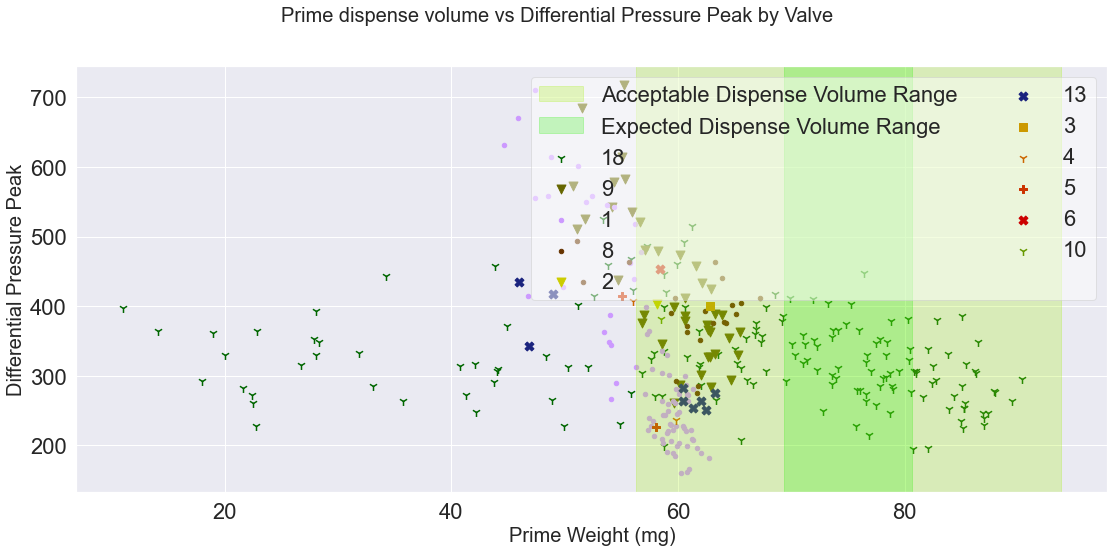

In [35]:
fig, ax = plt.subplots(figsize=(16, 8))
primes_df = full_df.loc[full_df['volume_ul'] == 75].copy()
valves = primes_df['valve_num'].unique()
for valve in valves:
    valve_df = primes_df.loc[primes_df['valve_num'] == valve].copy()
    ax.scatter(valve_df['weight_mg'], valve_df['peak'], label="{}".format(valve), 
               color=valve_color_map[valve][0], marker=valve_color_map[valve][1], s=80)
ax.axvspan(range_dict[75]['acceptable'][0], range_dict[75]['acceptable'][1], color='#A5F10B', alpha=0.25, 
           label='Acceptable Dispense Volume Range')
ax.axvspan(range_dict[75]['expected'][0], range_dict[75]['expected'][1], color='#2FF10B', alpha=0.25, 
           label='Expected Dispense Volume Range')
# ax.tick_params(axis='both', which='major', labelsize=15)
plt.xlabel('Prime Weight (mg)', fontsize=20)
plt.ylabel('Differential Pressure Peak', fontsize=20)
fig.suptitle('Prime dispense volume vs Differential Pressure Peak by Valve', fontsize=20)
plt.tight_layout()
ax.legend(facecolor='white', framealpha=0.5, ncol=2, loc='upper right')
plt.show()


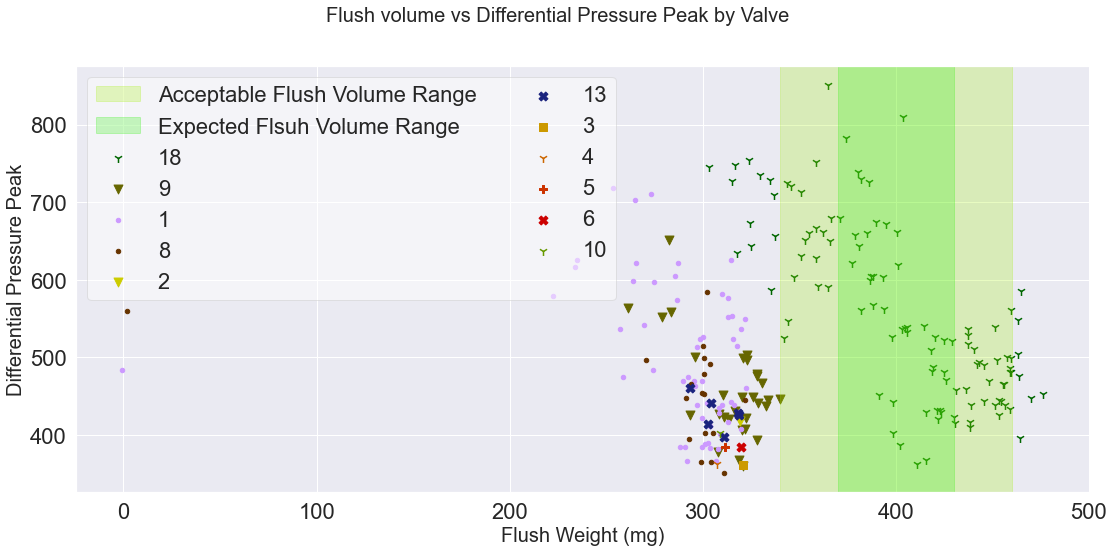

In [36]:
fig, ax = plt.subplots(figsize=(16, 8))
flushes_df = full_df.loc[(full_df['volume_ul'] == 400) & (full_df['dispense_type'] == 'flush')].copy()
valves = flushes_df['valve_num'].unique()
for valve in valves:
    valve_df = flushes_df.loc[flushes_df['valve_num'] == valve].copy()
    ax.scatter(valve_df['weight_mg'], valve_df['peak'], label="{}".format(valve), 
               color=valve_color_map[valve][0], marker=valve_color_map[valve][1], s=80)
ax.axvspan(range_dict[400]['acceptable'][0], range_dict[400]['acceptable'][1], color='#A5F10B', alpha=0.25, 
           label='Acceptable Flush Volume Range')
ax.axvspan(range_dict[400]['expected'][0], range_dict[400]['expected'][1], color='#2FF10B', alpha=0.25, 
           label='Expected Flsuh Volume Range')
# ax.tick_params(axis='both', which='major', labelsize=15)
plt.xlabel('Flush Weight (mg)', fontsize=20)
plt.ylabel('Differential Pressure Peak', fontsize=20)
fig.suptitle('Flush volume vs Differential Pressure Peak by Valve', fontsize=20)
plt.tight_layout()
ax.legend(facecolor='white', framealpha=0.5, ncol=2, loc='upper left')
plt.show()

- All peaks for WB1 (valve 18) appear to be normal throughout the range of priming volumes. Valve 1 and valve 9 show some Differential pressure peaks that are outside the normal range. Without data from other runs on the same instrument it is difficult to say if this observation is difficult to determine if this is a useful observation. However, it does appear that priming dispense volume is inversely proportional to Differential pressure peak height, which could indicate air in the dispense
- There appears to be two distinct groups for the flush volumes vs differential pressure peak. Valve 18 (the only bulk reagent on this plot) has a lower response of differential pressure peak to volume dispensed. However, both groups have inversely proportional peak heights to flush weights. This may suggest some air entrainment resulting in lower flushing weights but higher differential pressure peaks.
- There are two flush outliers. One for valve 8 and one for valve 1. The differential pressure peaks are nominal. These may be load cell errors, but it is not possible to tell from the data at hand.

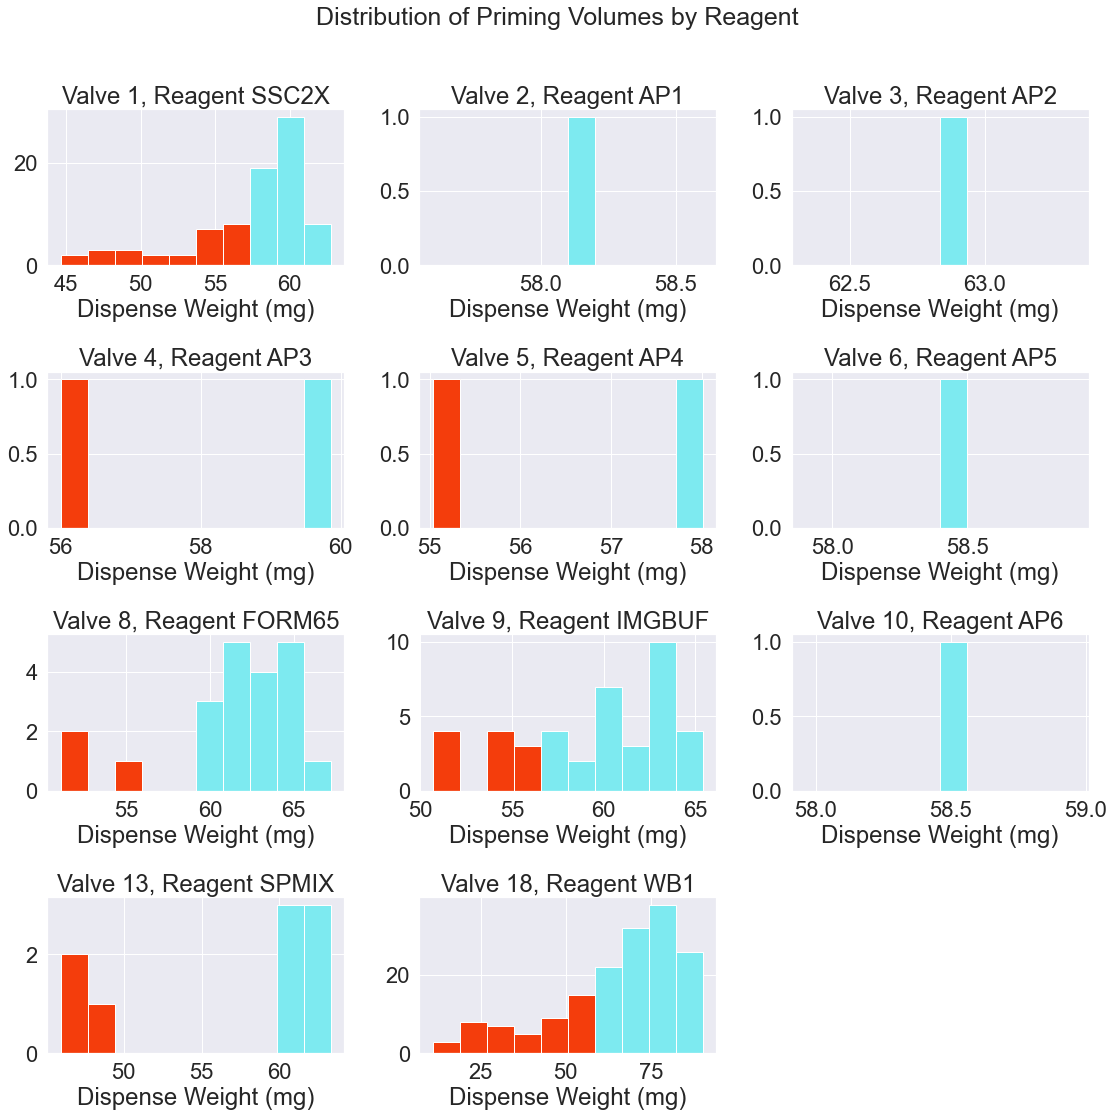

In [37]:
import math
primes_df = full_df.loc[full_df['volume_ul'] == 75].copy()
fig = plt.figure(figsize=(16, math.ceil(len(reagent_map)/3)*4))
for valve, i in zip(reagent_map, range(1, len(reagent_map) + 1)):
    ax = fig.add_subplot(math.ceil(len(reagent_map)/3), 3, i)
    temp_df = primes_df.loc[primes_df['valve_num']==valve]
    N, bins, patches = ax.hist(temp_df['weight_mg'])
#     ax.hist(temp_df['weight_mg'])
    for bin_, patch in zip(bins, patches):
        if bin_ < 56.25:
            patch.set_facecolor('#F43D0C')
        else:
            patch.set_facecolor('#7DEAF0')
    ax.set(xlabel='Dispense Weight (mg)', 
           title='Valve {}, Reagent {}'.format(valve, temp_df['reagent'].iloc[0]))
#     if temp_df.shape[0] > 1:
#         ax.axvspan(temp_df['weight_mg'].min(), 56.25, alpha=0.25, color='#F43D0C')
#         ax.axvspan(56.25, temp_df['weight_mg'].max(), alpha=0.25, color='#7DEAF0')
#         ax.axvline(75 - 75*.25, color='k')
fig.suptitle('Distribution of Priming Volumes by Reagent\n', fontsize=25)
plt.tight_layout()
plt.show()

In [38]:
prime_failures = primes_df.loc[primes_df['weight_mg'] < 56.25].shape[0]
total_primes = primes_df.shape[0]
prime_fail_ratio = prime_failures / total_primes

- All valves except for AP1, AP2, AP5, and AP6 required at least one retry of the prime. The mean priming volume was less than 75ul for all reagents.
- Ratio of retries to total priming attempts for valve 18 vs the rest of the valves combines was 0.33 and 0.35 respectively. Overall, valve 18 (WB1) was not worse than the other valves in this respect. However, it did have many more consecutive retries

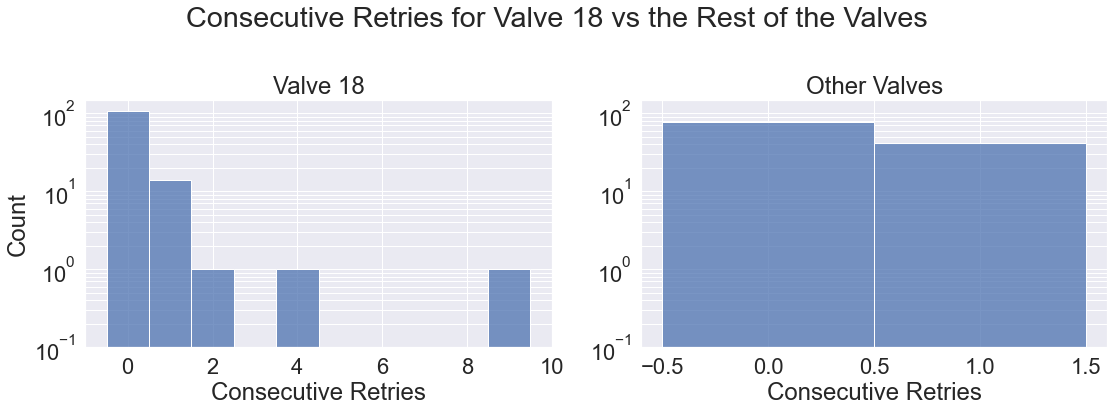

In [39]:
# Determine retries
fig = plt.figure(figsize=(16, 6))
temp_df = full_df.loc[full_df['valve_num'] == bad_valve].copy()
i = 0
retries = []
while i < temp_df.shape[0]:
    counter = 0
    if temp_df['volume_ul'].iloc[i] == 5:
        j = 1
        while (temp_df['volume_ul'].iloc[i + j] == 5 or temp_df['volume_ul'].iloc[i + j] == 75):
            counter += 1
            j += 1
        if retries == 1:
            retries.append(0)
        else:
            retries.append(int((counter/3)+(1/3)))
        i = i+j
    else:
        i += 1
ax = fig.add_subplot(1, 2, 1)
# fig, ax = plt.subplots()
sns.histplot(retries, discrete=True)
ax.yaxis.grid(True, which='minor')
ax.set(yscale='log')
ax.set(xlabel='Consecutive Retries', title='Valve {}'.format(bad_valve), ylim=(0.1, 150))

temp_df = full_df.loc[full_df['valve_num'] != bad_valve].copy()
i = 0
retries = []
while i < temp_df.shape[0]:
    counter = 0
    if temp_df['volume_ul'].iloc[i] == 5:
        j = 1
        while (temp_df['volume_ul'].iloc[i + j] == 5 or temp_df['volume_ul'].iloc[i + j] == 75):
            counter += 1
            j += 1
        if retries == 1:
            retries.append(0)
        else:
            retries.append(int((counter/3)+(1/3)))
        i = i+j
    else:
        i += 1
ax = fig.add_subplot(1, 2, 2)
sns.histplot(retries, discrete=True)
ax.yaxis.grid(True, which='minor')
ax.set(yscale='log')
ax.set(xlabel='Consecutive Retries', ylabel='', title='Other Valves', ylim=(0.1, 150))
fig.suptitle('Consecutive Retries for Valve {} vs the Rest of the Valves'.format(bad_valve))
plt.tight_layout()
plt.show()

- All other valves combined had many priming retries, but all recovered without error within the allotted retry attempts. 
- Valve 18 had 3 occasions where retries were greater than 1 (2, 4, and 9 retries).

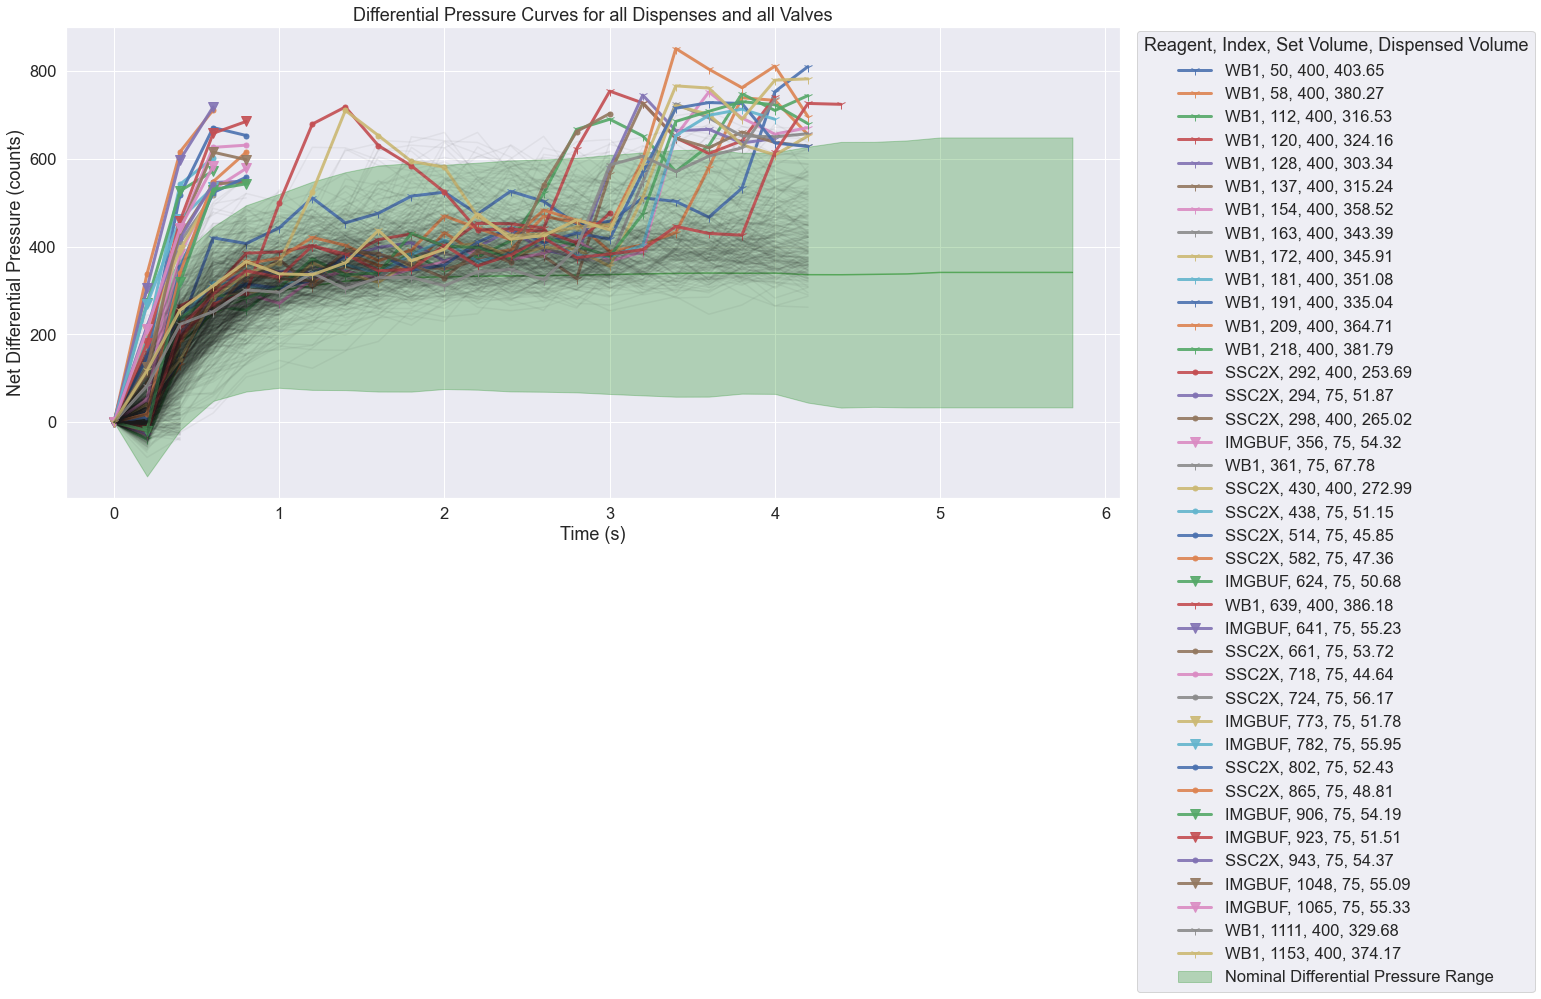

In [47]:
detected_air_dispenses = 0
valves = reagent_map
colors = ['#FFCC00', '#FF9900', '#FF6600', 
          '#FF3300', '#990000', '#999900', 
          '#99CC00', '#33FF00', '#336600', 
          '#336600', '#330000', 'k']
value_color_dict = dict(zip(valves, colors))
fig, ax = plt.subplots(figsize=(16,8))
temp_df = full_df.loc[full_df['valve_num'].isin(reagent_map)].copy()
# bad_valve_df = temp_df.loc[temp_df['valve_num'] == bad_valve].copy()

new_df = pd.read_csv('curve_data/average_pressure_curve.csv')
time = [a/5 for a in range(new_df.shape[0])]
ax.plot(time, new_df['mean_array'], color='green', alpha=0.5)
ax.fill_between(time, 
                new_df['mean_array'] + 3*new_df['stdev_array'], 
                new_df['mean_array'] - 3*new_df['stdev_array'], 
                color='green', alpha=0.25, label='Nominal Differential Pressure Range')
max_mean = max(new_df['mean_array'])
max_stdev = max(new_df['stdev_array'])
max_peak = max_mean + 3 * max_stdev 

for i in range(temp_df.shape[0]):
    curve = temp_df['pressure_curves'].iloc[i]
    length = range(len(curve))
    time = [a/5 for a in length]
    ax.plot(time, curve, alpha=0.05, color='k')
    bounds_list = curve - (new_df['mean_array'] + 4*new_df['stdev_array'])[:len(curve)]
    inside_norm = all(i <= 0 for i in bounds_list)
    if not inside_norm:
#     if (temp_df['peak'].iloc[i] >  max_peak):
        detected_air_dispenses += 1
        ax.plot(time, curve, alpha=0.9,
               marker=valve_color_map[temp_df['valve_num'].iloc[i]][1], markersize=10,
               linewidth=3, label='{}, {}, {}, {:.2f}'
               .format(temp_df['reagent'].iloc[i], i, temp_df['volume_ul'].iloc[i], temp_df['weight_mg'].iloc[i]))
     
sns.set(font_scale=1.5)
ax.set(xlabel='Time (s)', ylabel='Net Differential Pressure (counts)',
      title='Differential Pressure Curves for all Dispenses and all Valves')
fig.legend(bbox_to_anchor=[1.35,0.94], title='Reagent, Index, Set Volume, Dispensed Volume')
plt.tight_layout()
plt.show()

In [41]:
my_list = curve - (new_df['mean_array'] + 3*new_df['stdev_array'])[:len(curve)]
all(i <= 0 for i in my_list)

True

- The plot above shows all differntial pressure data from all dispenses from all valves. For the most part the plots look normal. There are some potential outliers, especially for some of the priming dispenses, but they are smaller than one would expect for a purely air dispense. We require data from other runs to relate these numbers to.

### 3. Valve 18 Run Analysis

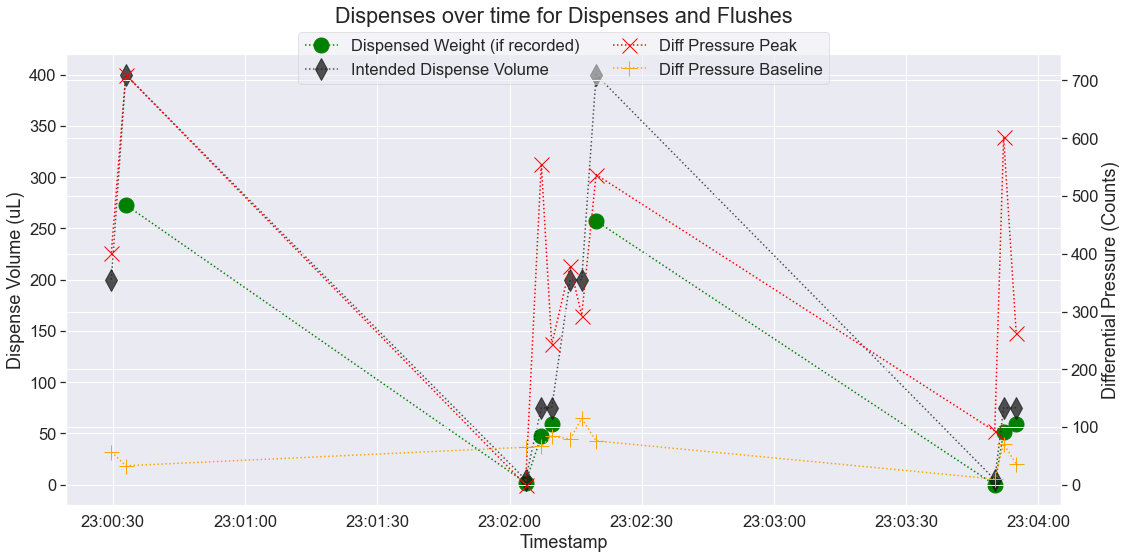

In [42]:
# Zoom in on problem areas

fig, ax = plt.subplots(figsize=(16, 8))
ax2 = ax.twinx()

beg = 429
end = 440

ax2.plot(temp_df['local_ts'].iloc[beg: end], 
         temp_df['peak'].iloc[beg:end], 
         marker='x', linestyle=':', 
         label='Diff Pressure Peak', 
         color='red', markersize=15)
ax2.plot(temp_df['local_ts'].iloc[beg: end], 
         temp_df['baseline'].iloc[beg:end], marker='+', 
         linestyle=':', 
         label='Diff Pressure Baseline', 
         color='orange', markersize=15)
ax.plot(temp_df['local_ts'].iloc[beg:end], 
        temp_df['weight_mg'].iloc[beg:end], 
        marker='o', linestyle=':', 
        label='Dispensed Weight (if recorded)', 
        color='green', markersize=15)
ax.plot(temp_df['local_ts'].iloc[beg:end], 
        temp_df['volume_ul'].iloc[beg:end], 
        marker='d', linestyle=':', 
        label='Intended Dispense Volume', 
        alpha=0.75, color='k', markersize=15)
# ax.axhspan(range_dict[400]['acceptable'][0], 
#            range_dict[400]['acceptable'][1], 
#            color='#A5F10B', alpha=0.25, 
#            label='Acceptable Dispense Volume Range')
# ax.axhspan(range_dict[400]['expected'][0], 
#            range_dict[400]['expected'][1], 
#            color='#2FF10B', alpha=0.25, 
#            label='Expected Dispense Volume Range')
ax.set(xlabel='Timestamp', ylabel='Dispense Volume (uL)')
ax2.set(ylabel='Differential Pressure (Counts)')
fig.suptitle('Dispenses over time for Dispenses and Flushes')
fig.legend(loc='upper center', bbox_to_anchor=[.5, .95],
          ncol=2, framealpha=0.5)
plt.tight_layout()
plt.show()

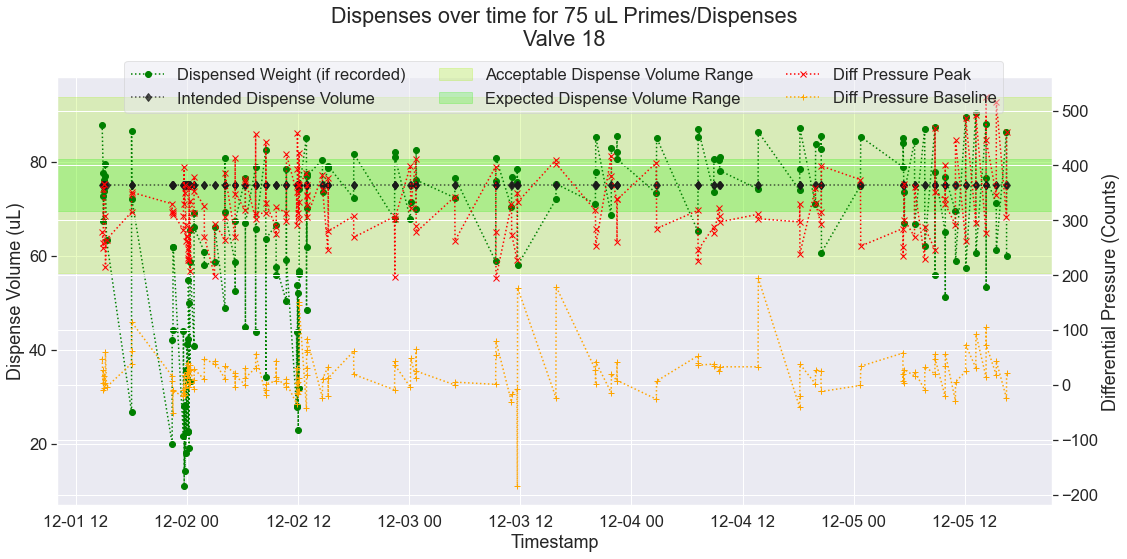

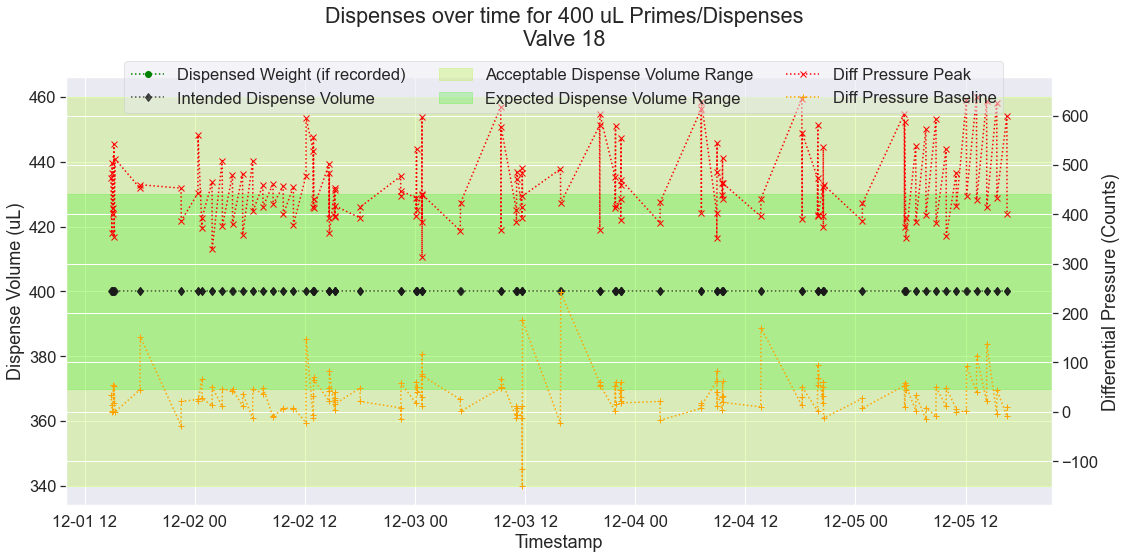

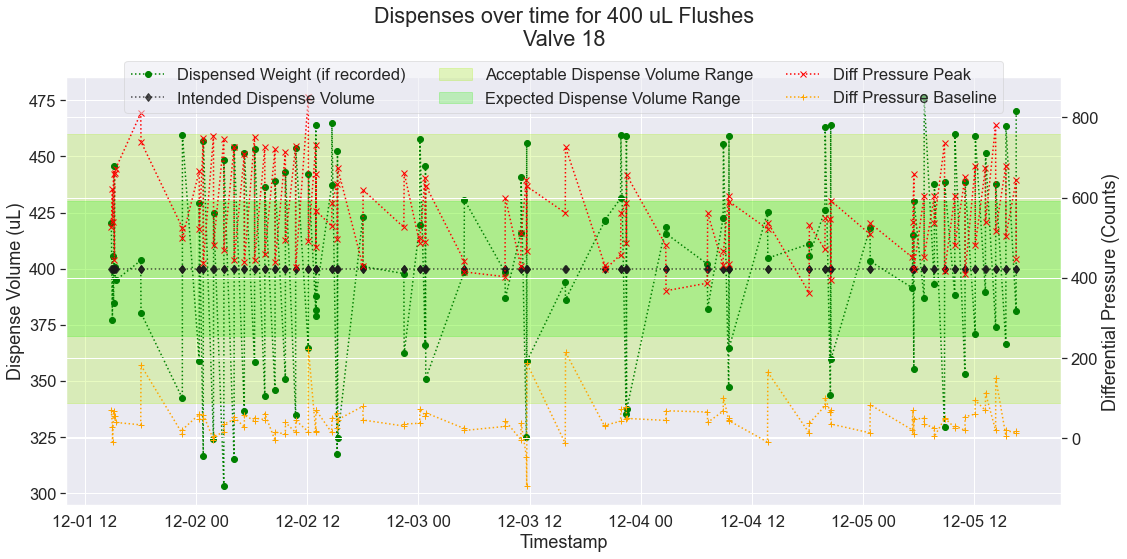

In [43]:
range_dict={5:{'acceptable': (0, 0),'expected': (0,0)}, 
                75:{'acceptable': (56.25, 93.75), 'expected': (69.375, 80.625)}, 
                200:{'acceptable': (170, 230), 'expected': (185, 215)}, 
                400:{'acceptable': (340, 460), 'expected': (370, 430)}}

df_18 = full_df.loc[(full_df['valve_num'] == bad_valve) & (full_df['dispense_type'] == 'reagent')].copy()
df_18_flush = full_df.loc[(full_df['valve_num'] == bad_valve) & (full_df['dispense_type'] == 'flush')].copy()
volumes = df_18['volume_ul'].unique()
for volume in volumes:
    if volume != 5:
        temp_df = df_18.loc[df_18['volume_ul'] == volume].copy()
        temp_df.to_csv('time_Series.csv')
        fig, ax = plt.subplots(figsize=(16, 8))
        ax2 = ax.twinx()
        ax2.plot(temp_df['local_ts'], temp_df['peak'], marker='x', linestyle=':',  label='Diff Pressure Peak', color='red')
        ax2.plot(temp_df['local_ts'], temp_df['baseline'], marker='+', linestyle=':', label='Diff Pressure Baseline', color='orange')
        ax.plot(temp_df['local_ts'], temp_df['weight_mg'], marker='o', linestyle=':', label='Dispensed Weight (if recorded)', color='green')
        ax.plot(temp_df['local_ts'], temp_df['volume_ul'], marker='d', linestyle=':', label='Intended Dispense Volume', alpha=0.75, color='k')
        ax.set(xlabel='Timestamp', ylabel='Dispense Volume (uL)')
        ax2.set(ylabel='Differential Pressure (Counts)')
        ax.axhspan(range_dict[volume]['acceptable'][0], range_dict[volume]['acceptable'][1], color='#A5F10B', alpha=0.25, 
                   label='Acceptable Dispense Volume Range')
        ax.axhspan(range_dict[volume]['expected'][0], range_dict[volume]['expected'][1], color='#2FF10B', alpha=0.25, 
                   label='Expected Dispense Volume Range')
        fig.suptitle('Dispenses over time for {} uL Primes/Dispenses\nValve {}'.format(volume, bad_valve))
        fig.legend(loc='upper center', bbox_to_anchor=[.5, 0.9],
          ncol=3, framealpha=0.5)
        plt.tight_layout()
        plt.show()
    
fig, ax = plt.subplots(figsize=(16, 8))
ax2 = ax.twinx()
ax2.plot(df_18_flush['local_ts'], df_18_flush['peak'], marker='x', linestyle=':', label='Diff Pressure Peak', color='red')
ax2.plot(df_18_flush['local_ts'], df_18_flush['baseline'], marker='+', linestyle=':', label='Diff Pressure Baseline', color='orange')
ax.plot(df_18_flush['local_ts'], df_18_flush['weight_mg'], marker='o', linestyle=':', label='Dispensed Weight (if recorded)', color='green')
ax.plot(df_18_flush['local_ts'], df_18_flush['volume_ul'], marker='d', linestyle=':', label='Intended Dispense Volume', alpha=0.75, color='k')
ax.axhspan(range_dict[400]['acceptable'][0], range_dict[400]['acceptable'][1], color='#A5F10B', alpha=0.25, 
           label='Acceptable Dispense Volume Range')
ax.axhspan(range_dict[400]['expected'][0], range_dict[400]['expected'][1], color='#2FF10B', alpha=0.25, 
           label='Expected Dispense Volume Range')
ax.set(xlabel='Timestamp', ylabel='Dispense Volume (uL)')
ax2.set(ylabel='Differential Pressure (Counts)')
fig.suptitle('Dispenses over time for {} uL Flushes\nValve {}'.format(400, bad_valve))
fig.legend(loc='upper center', bbox_to_anchor=[.5, 0.9],
          ncol=3, framealpha=0.5)
plt.tight_layout()
plt.show()
    # ax.set(xscale='log')

- The above plots show each dispense event (prime, dispense flush) for WB1 (valve 18). The X axis is the timestamp of the dispense event. 
- The black diamond signifies a dispense event, and is placed at the set volume for the dispense. 
- The green plot shows the weighed dispense volume. Note: this is only available for priming and flushing since we cannot measure when dispensed to wells.The green bands show the acceptable and expected volumes for a dispense or flush. 
- The orange and red plots show the baseline differential pressure sensor value and the peak differential pressure measured during the dispense (in raw counts). The higher the counts, the faster the flow of argon, which correlates well to instantaneous flow rate at the dispense tip. Very high values indicate air entrained in fluid flow or completely empty reagent reservoirs. 

### 4. Conclusions

- Without historical data to compare to, the value of this analysis is limited, however, some information can be gleaned regardless. 

1. About 30% of primes failed and required at least one retry. For valve 18 (WB1) as many as 9 retries were required. 
2. Limited data to show air bubbles in dispense line. However, without historical data or empirical data as a means to calibrate the differential pressure sensor data, it is difficult to rule this out. There is some evidence that there is an inverse relationship between peak and priming volume for some valves, which would indicate air entrained with the priming liquid during priming. This liquid comes from the water bulk, so the potential source of air would be from there. 
3. Bubbles entrained into the water line would explain much of the variance in priming volume and flush volume seen during the run, since this would affect all valves

### 5. Next Steps

1. Analyze historical datasets as comparison
2. Increase data collection frequency during dispenses. Current collection frequency is about 5 Hz. If there are small air bubbles we may miss these at lower sampling frequencies.
3. Check valves on Sequoia for leaks

In [44]:
# !jupyter nbconvert --to html --no-input Reagent_logs_analysis.ipynb --output 20201201_Sequoia_fluidics_debrief.html

In [45]:
# Save general calibration, prime data, and dispense data to csv file
timestamps = df_output['time'].unique()
dfs_summary = []
for timestamp in timestamps:
    new_dict = {}
    df_by_time = df_output.loc[df_output['time'] == timestamp].copy()
    df_dict = df_by_time.to_dict(orient='list')
    new_dict['instrument'] = instrument
    new_dict['time'] = df_dict['time'][0]
    new_dict['valves'] = [df_dict['valve']]
    new_dict['Lavg'] = [df_dict['Lavg']]
    new_dict['Lstdev'] = [df_dict['Lstdev']]
    new_dict['prime_failures'] = prime_failures
    new_dict['prime_fail_ratio'] = prime_fail_ratio
    new_dict['detected_air_dispenses'] = detected_air_dispenses
    df_summary = pd.DataFrame(new_dict)
    dfs_summary.append(df_summary)
try:
    existing_summary_df = pd.read_csv('historical_data/summary_data.csv')
    dfs_summary.insert(0, existing_summary_df)
except:
    pass
df_summary = pd.concat(dfs_summary)
if write_to:
    df_summary.to_csv('historical_data/summary_data.csv', index=False)